## 0. Configurations

In [1]:
# ====================================================================
# Configuration 설정
# ====================================================================
# 하이퍼파라미터 및 경로 등 실험에 필요한 설정들을 모아둠
# 실험 추적 및 재현성을 위해 모든 값은 여기에서 수정하고자 함
import os  # 디렉토리, 파일 경로 조작 등

import torch
import os
import numpy as np

from pathlib import Path  # payhon path

import albumentations as A
import cv2  # OpenCV - 고급 이미지/비디오 처리
import torch
from torch.utils.data import Dataset  # 커스텀 데이터셋, 배치 로딩
import pandas as pd
import os
import json
from tqdm import tqdm
from pathlib import Path

# Garbage Collector 모듈
import gc

from torchmetrics.detection.mean_ap import MeanAveragePrecision


# 메모리 정리 루틴
gc.collect()
torch.cuda.empty_cache()


# --- 디바이스 설정 ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42

# --- 학습 하이퍼파라미터 ---
BATCH_SIZE = 16
NUM_EPOCHS = 200
LEARNING_RATE = 1e-4
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

# --- 데이터 경로 설정 ---
# DATA_ROOT = path
# DATA_ROOT = "data/raw/ai03-level1-project/"  # 경로
# TRAIN_IMAGE_DIR = os.path.join(DATA_ROOT, "train_images")
# TRAIN_ANNO_DIR = os.path.join(DATA_ROOT, "train_annotations")
# TEST_IMAGE_DIR = os.path.join(DATA_ROOT, "test_images")
# PROCESSED_TRAIN_CSV = "../data/processed/train_df.csv"  # 데이터 전처리된 csv 파일

# --- 모델 설정 ---
NUM_CLASSES = 73
MODEL_NAME = "fasterrcnn_resnet50_fpn"
USE_PRETRAINED = True

# --- 학습 고도화 설정 ---
USE_SCHEDULER = True  # Learning rate scheduler 사용 여부
EARLY_STOPPING = True  # Early stopping 적용 여부
AUGMENTATION = True  # 데이터 증강 사용 여부

# --- 실험 로깅용 설정 ---
USE_WANDB = True
WANDB_PROJECT = "AI03-Project-1"
RUN_NAME = f"{MODEL_NAME}_bs{BATCH_SIZE}_lr{LEARNING_RATE}"


# --- 실험 결과 저장 경로 ---
EXPERIMENT_DIR = "../experiments"

## 1. Data-preprocessing

In [2]:
def parse_raw_annotations(ann_dir: Path) -> pd.DataFrame:
    """
    복잡한 3중 폴더 구조의 원본 어노테이션을 파싱하여
    하나의 Pandas DataFrame으로 반환하는 함수.
    """
    all_annotations = []

    # Level 1: 이미지별 폴더 순회
    image_level_dirs = os.listdir(ann_dir)
    for image_dir_name in tqdm(image_level_dirs, desc="[L1] Images"):
        image_dir_path = ann_dir / image_dir_name
        if not image_dir_path.is_dir():
            continue

        # Level 2: 알약 종류 폴더 순회
        pill_level_dirs = os.listdir(image_dir_path)
        for pill_dir_name in pill_level_dirs:
            pill_dir_path = image_dir_path / pill_dir_name
            if not pill_dir_path.is_dir():
                continue

            # Level 3: 실제 .json 파일 파싱
            json_files = [f for f in os.listdir(pill_dir_path) if f.endswith(".json")]
            if not json_files:
                continue

            # 첫 번째 json 파일만 사용
            json_file_path = pill_dir_path / json_files[0]

            try:
                with open(json_file_path, "r", encoding="utf-8") as f:
                    ann_data = json.load(f)

                    image_info = ann_data.get("images", [{}])[0]
                    annotation_info = ann_data.get("annotations", [{}])[0]
                    category_info = ann_data.get("categories", [{}])[0]

                    all_annotations.append(
                        {
                            "image_id": image_info.get("id"),
                            "file_name": image_info.get("file_name"),
                            "width": image_info.get("width"),
                            "height": image_info.get("height"),
                            "category_id": category_info.get("id"),
                            "class_name": category_info.get("name"),
                            "bbox": annotation_info.get("bbox"),
                        }
                    )
            except Exception as e:
                print(f"\n파일 처리 에러: {json_file_path}, 에러: {e}")

    return pd.DataFrame(all_annotations)

In [3]:
# 1. 핵심 함수를 호출해서 DataFrame 생성
from pathlib import Path

BASE_DIR = Path("../")  # 상대경로
RAW_DATA_DIR = BASE_DIR / "data/raw/ai03-level1-project"
PROCESSED_DATA_DIR = BASE_DIR / "data/processed"

TRAIN_IMAGE_DIR = RAW_DATA_DIR / "train_images"
TRAIN_ANNO_DIR = RAW_DATA_DIR / "train_annotations"
TEST_IMAGE_DIR = RAW_DATA_DIR / "test_images"
SAVE_PATH = PROCESSED_DATA_DIR / "train_df.csv"
train_df = parse_raw_annotations(TRAIN_ANNO_DIR)

# --- (1). bbox 컬럼을 4개로 분리 ---
# bbox 컬럼 분리
bbox_df = pd.DataFrame(
    train_df["bbox"].tolist(), columns=["bbox_x", "bbox_y", "bbox_w", "bbox_h"]
)
train_df = pd.concat([train_df.drop("bbox", axis=1), bbox_df], axis=1)

# ✨ --- [핵심 수정] 잘못된 바운딩 박스 데이터 제거 ---
# xmax (bbox_x + bbox_w)가 이미지 너비(width)를 초과하는 경우
invalid_x = train_df["bbox_x"] + train_df["bbox_w"] > train_df["width"]
# ymax (bbox_y + bbox_h)가 이미지 높이(height)를 초과하는 경우
invalid_y = train_df["bbox_y"] + train_df["bbox_h"] > train_df["height"]

# 잘못된 데이터를 필터링
invalid_rows = train_df[invalid_x | invalid_y]
if not invalid_rows.empty:
    print(f"--- {len(invalid_rows)}개의 잘못된 바운딩 박스 데이터를 찾았습니다. ---")
    print(
        invalid_rows[
            ["file_name", "width", "height", "bbox_x", "bbox_y", "bbox_w", "bbox_h"]
        ]
    )

    # 유효한 데이터만 남김
    train_df = train_df[~(invalid_x | invalid_y)]
    print(f"\n잘못된 데이터를 제거하고, {len(train_df)}개의 데이터만 사용합니다.")

# --- (2). category_id를 새로운 label_idx로 매핑 ---
# 고유한 category_id 목록을 뽑아 정렬
unique_category_ids = sorted(train_df["category_id"].unique())
NUM_CLASSES = len(unique_category_ids)
# category_id를 0, 1, 2... 인덱스로 변환하는 딕셔너리 생성
id_to_idx = {
    int(original_id): idx
    for idx, original_id in enumerate(
        unique_category_ids, start=1
    )  # <--- start=1 추가!
}
# 이 매핑 정보를 사용해서 'label_idx'라는 새 컬럼을 추가
train_df["label_idx"] = train_df["category_id"].map(id_to_idx)

# 나중에 추론 결과에서 원래 클래스 이름을 찾을 수 있도록 매핑 정보도 저장
label_map = {
    "id_to_idx": id_to_idx,
    "idx_to_id": {idx: int(original_id) for original_id, idx in id_to_idx.items()},
    "id_to_name": dict(zip(train_df["category_id"], train_df["class_name"])),
}
with open(PROCESSED_DATA_DIR / "label_map.json", "w", encoding="utf-8") as f:
    json.dump(label_map, f, ensure_ascii=False, indent=4)

print(f"\n총 {len(unique_category_ids)}개의 고유 클래스를 발견했습니다.")
print("라벨 매핑 정보를 'data/processed/label_map.json'에 저장했습니다.")


# 3. 최종 DataFrame을 CSV 파일로 저장
train_df.to_csv(SAVE_PATH, index=False)

print(f"\n--- 데이터 전처리 및 저장 완료! ---")
print(train_df.head())

[L1] Images:   8%|▊         | 38/498 [00:00<00:01, 372.35it/s]

[L1] Images: 100%|██████████| 498/498 [00:01<00:00, 348.54it/s]

--- 1개의 잘못된 바운딩 박스 데이터를 찾았습니다. ---
                                          file_name  width  height  bbox_x  \
1253  K-003351-016262-018357_0_2_0_2_75_000_200.png    976    1280    6567   

      bbox_y  bbox_w  bbox_h  
1253     625     311     315  

잘못된 데이터를 제거하고, 1875개의 데이터만 사용합니다.

총 73개의 고유 클래스를 발견했습니다.
라벨 매핑 정보를 'data/processed/label_map.json'에 저장했습니다.

--- 데이터 전처리 및 저장 완료! ---
   image_id                                          file_name  width  height  \
0       477  K-002483-013395-019552-025438_0_2_0_2_90_000_2...    976    1280   
1       477  K-002483-013395-019552-025438_0_2_0_2_90_000_2...    976    1280   
2       476  K-002483-013395-019552-025438_0_2_0_2_70_000_2...    976    1280   
3       476  K-002483-013395-019552-025438_0_2_0_2_70_000_2...    976    1280   
4      1406      K-003351-033880-038162_0_2_0_2_70_000_200.png    976    1280   

   category_id         class_name  bbox_x  bbox_y  bbox_w  bbox_h  label_idx  
0         2482        뮤테란캡슐 100mg     603   

<Axes: xlabel='label_idx'>

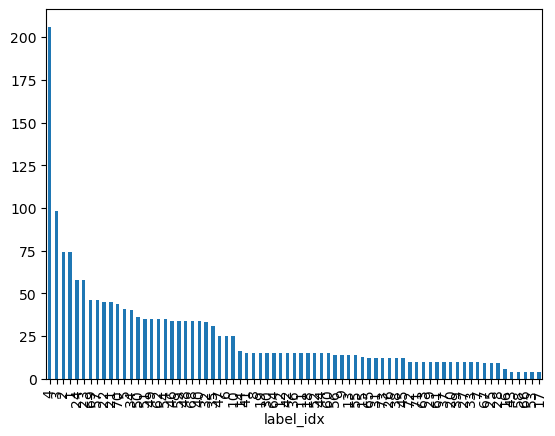

In [4]:
train_df["label_idx"].value_counts().plot(kind="bar")

In [5]:
train_df["class_name"].value_counts()

class_name
기넥신에프정(은행엽엑스)(수출용)    206
일양하이트린정 2mg            98
뮤테란캡슐 100mg            74
보령부스파정 5mg             74
동아가바펜틴정 800mg          58
                     ... 
쿠에타핀정 25mg              4
렉사프로정 15mg              4
브린텔릭스정 20mg             4
졸로푸트정 100mg             4
자이프렉사정 2.5mg            4
Name: count, Length: 73, dtype: int64

In [6]:
classes_tmp = train_df["class_name"].unique()
classes_tmp

array(['뮤테란캡슐 100mg', '큐시드정 31.5mg/PTP', '트루비타정 60mg/병',
       '써스펜8시간이알서방정 650mg', '글리틴정(콜린알포세레이트)', '일양하이트린정 2mg',
       '로수바미브정 10/20mg', '제미메트서방정 50/1000mg', '노바스크정 5mg',
       '기넥신에프정(은행엽엑스)(수출용)', '아토젯정 10/40mg', '트라젠타듀오정 2.5/850mg',
       '리피토정 20mg', '동아가바펜틴정 800mg', '울트라셋이알서방정', '보령부스파정 5mg',
       '케이캡정 50mg', '자누비아정 50mg', '로수젯정10/5밀리그램', '아모잘탄정 5/100mg',
       '트라젠타정(리나글립틴)', '크레스토정 20mg', '가바토파정 100mg', '란스톤엘에프디티정 30mg',
       '펠루비정(펠루비프로펜)', '콜리네이트연질캡슐 400mg', '자누메트정 50/850mg', '카나브정 60mg',
       '플라빅스정 75mg', '리바로정 4mg', '글리아타민연질캡슐', '리피로우정 20mg',
       '트윈스타정 40/5mg', '엑스포지정 5/160mg', '아토르바정 10mg', '카발린캡슐 25mg',
       '에빅사정(메만틴염산염)(비매품)', '다보타민큐정 10mg/병', '삼남건조수산화알루미늄겔정',
       '리렉스펜정 300mg/PTP', '타이레놀이알서방정(아세트아미노펜)(수출용)', '삐콤씨에프정 618.6mg/병',
       '쎄로켈정 100mg', '무코스타정(레바미피드)(비매품)', '낙소졸정 500/20mg',
       '종근당글리아티린연질캡슐(콜린알포세레이트)\xa0', '오마코연질캡슐(오메가-3-산에틸에스테르90)',
       '리리카캡슐 150mg', '에스원엠프정 20mg', '레일라정', '세비카정 10/40mg', '스토가정 10mg',
       '알드린정', '메가파워정 

In [7]:
# 1. 'category_id'와 'class_name' 컬럼으로 고유한 쌍을 찾고, ID 기준으로 정렬
class_mapping_df = (
    train_df[["category_id", "class_name"]]
    .drop_duplicates()
    .sort_values(by="category_id")
)
# 2. 정렬된 DataFrame에서 클래스 이름만 리스트로 추출
sorted_class_names = [
    name.split("(")[0].strip() for name in class_mapping_df["class_name"]
]
# 3. 맨 앞에 'background' 추가
classes = ["background"] + sorted_class_names

print(f"총 클래스 개수 (배경 포함): {len(classes)}")
print(f"클래스 리스트: {classes}")

총 클래스 개수 (배경 포함): 74
클래스 리스트: ['background', '보령부스파정 5mg', '뮤테란캡슐 100mg', '일양하이트린정 2mg', '기넥신에프정', '무코스타정', '알드린정', '뉴로메드정', '타이레놀정500mg', '에어탈정', '삼남건조수산화알루미늄겔정', '타이레놀이알서방정', '삐콤씨에프정 618.6mg/병', '조인스정 200mg', '쎄로켈정 100mg', '리렉스펜정 300mg/PTP', '아빌리파이정 10mg', '자이프렉사정 2.5mg', '다보타민큐정 10mg/병', '써스펜8시간이알서방정 650mg', '에빅사정', '리피토정 20mg', '크레스토정 20mg', '가바토파정 100mg', '동아가바펜틴정 800mg', '오마코연질캡슐', '란스톤엘에프디티정 30mg', '리리카캡슐 150mg', '종근당글리아티린연질캡슐', '콜리네이트연질캡슐 400mg', '트루비타정 60mg/병', '스토가정 10mg', '노바스크정 5mg', '마도파정', '플라빅스정 75mg', '엑스포지정 5/160mg', '펠루비정', '아토르바정 10mg', '라비에트정 20mg', '리피로우정 20mg', '자누비아정 50mg', '맥시부펜이알정 300mg', '메가파워정 90mg/병', '쿠에타핀정 25mg', '비타비백정 100mg/병', '놀텍정 10mg', '자누메트정 50/850mg', '큐시드정 31.5mg/PTP', '아모잘탄정 5/100mg', '세비카정 10/40mg', '트윈스타정 40/5mg', '카나브정 60mg', '울트라셋이알서방정', '졸로푸트정 100mg', '트라젠타정', '비모보정 500/20mg', '레일라정', '리바로정 4mg', '렉사프로정 15mg', '트라젠타듀오정 2.5/850mg', '낙소졸정 500/20mg', '아질렉트정', '자누메트엑스알서방정 100/1000mg', '글리아타민연질캡슐', '신바로정', '에스원엠프정 20mg', '브린텔릭스정 20mg', '글리틴정', '제

## 2. Load a model

In [8]:
# (1) 데이터 증강 (Augmentation) : Albumentations 라이브러리 사용
train_transforms = A.Compose(
    [
        A.Resize(512, 512),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        # PyTorch 텐서로 변환
        A.pytorch.ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="albumentations", label_fields=["labels"]),
)  # bbox 형식은 pascal_voc: [xmin, ymin, xmax, ymax]

val_transforms = A.Compose(
    [
        A.Resize(512, 512),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.pytorch.ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="albumentations", label_fields=["labels"]),
)

test_transforms = A.Compose(
    [
        A.Resize(512, 512),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.pytorch.ToTensorV2(),
    ]
)


# DataLoader를 위한 collate_fn. 이미지와 타겟을 리스트로 묶어줌
def collate_fn(batch):
    return tuple(zip(*batch))

In [9]:
class PillDataset(Dataset):
    # --- mode 파라미터 추가 및 df를 직접 받도록 수정 ---
    def __init__(self, df, image_dir, mode="train", transforms=None):
        self.df = df
        self.image_dir = Path(image_dir)
        self.mode = mode
        self.transforms = transforms

        # --- image_ids를 미리 뽑아 중복을 제거 ---
        # df['file_name']을 사용하면 이미지 파일 이름으로 고유한 이미지를 식별 가능.
        self.image_ids = self.df["file_name"].unique()

    def __len__(self):
        # --- 고유한 이미지의 개수를 반환 ---
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = self.image_dir / image_id

        image = cv2.imread(str(image_path))
        if image is None:
            raise FileNotFoundError(
                f"Error: Could not load image at path: {image_path}"
            )

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape

        if self.mode in ["train", "val"]:
            records = self.df[self.df["file_name"] == image_id]
            boxes = records[["bbox_x", "bbox_y", "bbox_w", "bbox_h"]].values

            boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
            boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

            labels = records["label_idx"].values

            # print(f"\n[DEBUG 1] Image: {image_id}, Original Pixel Coords:\n{boxes}")

            # 바운딩 박스 좌표 정규화
            boxes = boxes.astype(np.float32)
            boxes[:, [0, 2]] /= w
            boxes[:, [1, 3]] /= h

            # print(f"[DEBUG 2] Normalized Coords for Albumentations:\n{boxes}")

            if self.transforms:
                try:
                    transformed = self.transforms(
                        image=image, bboxes=boxes, labels=labels
                    )
                    image = transformed["image"]
                    boxes = transformed["bboxes"]
                    labels = transformed["labels"]
                except Exception as e:
                    print(f"!!!!!!!!!!!!!! Albumentations에서 에러 발생 !!!!!!!!!!!!!!")
                    print(f"Image: {image_id}")
                    print(f"Boxes sent to transform: {boxes}")
                    # raise e  # 에러를 다시 발생시켜서 멈추게 함

            # ... 이하 코드는 이전과 동일 ...
            _, new_h, new_w = image.shape
            boxes = torch.as_tensor(boxes, dtype=torch.float32)

            if len(boxes) > 0:
                boxes[:, [0, 2]] *= new_w
                boxes[:, [1, 3]] *= new_h

            target = {
                "boxes": boxes,
                "labels": torch.as_tensor(labels, dtype=torch.int64),
            }

            if len(target["boxes"]) == 0:
                target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)
                target["labels"] = torch.zeros((0,), dtype=torch.int64)

            return image, target

            # 테스트 모드일 경우, 이미지와 파일 이름만 반환
        elif self.mode == "test":
            # 테스트 시에는 보통 기본적인 리사이즈, 정규화만 적용
            if self.transforms:
                transformed = self.transforms(image=image)
                image = transformed["image"]

            # 나중에 예측 결과를 이미지와 매칭시키기 위해 파일 이름을 반환
            return image, image_id


# 참고: Subset을 사용할 때 transform을 다르게 적용하려면 약간의 트릭이 필요.
# 먼저 transform이 없는 전체 데이터셋을 만듦.
# 각 Subset에 맞는 transform을 적용하는 Wrapper 클래스 생성
# class TransformSubset(Dataset):
#     def __init__(self, subset, transforms):
#         self.subset = subset
#         self.transforms = transforms

#     def __getitem__(self, idx):
#         image, target = self.subset[idx]

#         # NumPy 배열로 변환 (Albumentations 입력 형식)
#         boxes = target["boxes"].numpy()
#         labels = target["labels"].numpy()

#         if self.transforms:
#             transformed = self.transforms(image=image, bboxes=boxes, labels=labels)
#             image = transformed["image"]
#             target["boxes"] = torch.as_tensor(
#                 transformed["bboxes"], dtype=torch.float32
#             )
#             # 증강 후 bbox가 사라졌을 경우 처리
#             if len(target["boxes"]) == 0:
#                 target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)

#         return image, target

#     def __len__(self):
#         return len(self.subset)

In [10]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# pre-trained 모델 로드
# Faster R-CNN
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# MobileNetV3
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(
    weights="DEFAULT"
)


# 분류기의 입력 피처 수를 가져옴
in_features = model.roi_heads.box_predictor.cls_score.in_features

# pre-trained head를 새로운 head로 교체
# num_classes에 배경(background) 클래스 1개를 더해줘야 함
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES + 1)

In [11]:
import random


# 재현성을 위해 모든 난수 생성기의 시드를 고정하는 함수.
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Seed set to {seed}")

In [12]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedGroupKFold
from torch.utils.data import Subset

seed_everything(SEED)

# 1. 데이터 준비
df = pd.read_csv(SAVE_PATH)

# StratifiedGroupKFold를 위한 데이터 준비
groups = df["file_name"]  # 그룹 기준: 이미지 파일 이름
labels = df["category_id"]  # 층화 기준: 원본 클래스 ID

# K-Fold 설정 (5-fold, 즉 80% train / 20% val)
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)

# 첫 번째 fold의 train/val 인덱스를 가져옴
train_idxs, val_idxs = next(cv.split(df, labels, groups))
# 1. 인덱스를 사용해서 데이터프레임을 먼저 분할!
train_df_split = df.iloc[train_idxs].reset_index(drop=True)
val_df_split = df.iloc[val_idxs].reset_index(drop=True)

# 2. 분할된 데이터프레임으로 각각 Dataset 생성 (Subset, TransformSubset 불필요!)
train_dataset = PillDataset(
    df=train_df_split,
    image_dir=TRAIN_IMAGE_DIR,
    mode="train",
    transforms=train_transforms,
)

val_dataset = PillDataset(
    df=val_df_split,
    image_dir=TRAIN_IMAGE_DIR,
    mode="val",
    transforms=val_transforms,  # val_transforms 사용
)


test_df = pd.DataFrame({"file_name": os.listdir(TEST_IMAGE_DIR)})

test_dataset = PillDataset(
    df=test_df,
    image_dir=TEST_IMAGE_DIR,
    mode="test",
    transforms=test_transforms,
)


# --- Data Loader ---
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
)

Seed set to 42


/home/soohyun/ls/envs/JSH/lib/python3.12/site-packages/sklearn/model_selection/_split.py:1023: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


In [13]:
# img, image_id = next(iter(train_loader))
# image_id[7]

In [14]:
img, image_id = next(iter(val_loader))
image_id[7]

{'boxes': tensor([[ 78.1639,  73.2000, 187.8033, 154.0000],
         [ 72.9180, 310.8000, 196.7213, 400.0000]]),
 'labels': tensor([ 5, 23])}

In [15]:
model = model.to(DEVICE)

params = [p for p in model.parameters() if p.requires_grad]

# optimizer = torch.optim.SGD(
#     params,
#     lr=LEARNING_RATE,
#     momentum=MOMENTUM,
#     weight_decay=WEIGHT_DECAY,
# )
optimizer = torch.optim.AdamW(params, lr=LEARNING_RATE, weight_decay=0.01)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=NUM_EPOCHS, eta_min=1e-6
)

In [16]:
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

backbone.body.0.0.weight: requires_grad=False
backbone.body.1.block.0.0.weight: requires_grad=False
backbone.body.1.block.1.0.weight: requires_grad=False
backbone.body.2.block.0.0.weight: requires_grad=False
backbone.body.2.block.1.0.weight: requires_grad=False
backbone.body.2.block.2.0.weight: requires_grad=False
backbone.body.3.block.0.0.weight: requires_grad=False
backbone.body.3.block.1.0.weight: requires_grad=False
backbone.body.3.block.2.0.weight: requires_grad=False
backbone.body.4.block.0.0.weight: requires_grad=False
backbone.body.4.block.1.0.weight: requires_grad=False
backbone.body.4.block.2.fc1.weight: requires_grad=False
backbone.body.4.block.2.fc1.bias: requires_grad=False
backbone.body.4.block.2.fc2.weight: requires_grad=False
backbone.body.4.block.2.fc2.bias: requires_grad=False
backbone.body.4.block.3.0.weight: requires_grad=False
backbone.body.5.block.0.0.weight: requires_grad=False
backbone.body.5.block.1.0.weight: requires_grad=False
backbone.body.5.block.2.fc1.weig

In [17]:
# 3. 학습 루프
print("--- Start Training ---")
metric = MeanAveragePrecision(box_format="xyxy").to(DEVICE)
# early_stopping = EarlyStopping(patience=7, verbose=True, path=path_model)
train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    # ===================================
    #  Training Step
    # ===================================

    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{NUM_EPOCHS}]")

    for images, targets in loop:
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        running_loss += losses.item()
    avg_train_loss = running_loss / len(train_loader)

    scheduler.step()

    # =====================================
    #  Validation Step (✨ 여기가 핵심 수정)
    # =====================================
    model.eval()
    val_loss = 0.0
    metric.reset()
    # (2) Validation phase
    for images, targets in val_loader:
        images = [img.to(DEVICE) for img in images]
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        # 1. mAP 계산을 위한 예측 (그래디언트 계산 불필요)
        with torch.no_grad():  # 👈✨ 예측 부분만 no_grad로 감싸기
            predictions = model(images)

        # 2. Metric 업데이트
        metric.update(predictions, targets)

        # 3. Validation Loss 계산 (그래디언트 계산 필요)
        #    torch.no_grad() 블록 바깥에서 계산
        model.train()  # Loss 계산을 위해 잠시 train 모드로
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        val_loss += losses.item()
        model.eval()  # 다음 배치를 위해 다시 eval 모드로 복귀

    average_val_loss = val_loss / len(val_loader)
    val_losses.append(average_val_loss)

    # mAP 평가
    mAP_dict = metric.compute()
    # mAP = evaluate_model(all_predictions, all_ground_truths, classes)
    print(
        f"Train Loss: {avg_train_loss:.4f}, Val Loss: {average_val_loss:.4f}, Validation mAP: {mAP_dict['map_50']:.4f}"
    )

print("--- Finish Training ---"),
# 최종 모델 저장
# torch.save(model.state_dict(), f"{EXPERIMENT_DIR}/final_model.pt")

--- Start Training ---


Epoch [1/200]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1/200]: 100%|██████████| 40/40 [00:34<00:00,  1.17it/s]


Train Loss: 3.6458, Val Loss: 3.0503, Validation mAP: 0.1291


Epoch [2/200]: 100%|██████████| 40/40 [00:22<00:00,  1.81it/s]


Train Loss: 2.5753, Val Loss: 2.1426, Validation mAP: 0.5141


Epoch [3/200]: 100%|██████████| 40/40 [00:21<00:00,  1.82it/s]


Train Loss: 1.8627, Val Loss: 1.7534, Validation mAP: 0.6604


Epoch [4/200]: 100%|██████████| 40/40 [00:22<00:00,  1.80it/s]


Train Loss: 1.6416, Val Loss: 1.5458, Validation mAP: 0.7196


Epoch [5/200]: 100%|██████████| 40/40 [00:23<00:00,  1.70it/s]


Train Loss: 1.4072, Val Loss: 1.4196, Validation mAP: 0.7186


Epoch [6/200]: 100%|██████████| 40/40 [00:23<00:00,  1.69it/s]


Train Loss: 1.3753, Val Loss: 1.3540, Validation mAP: 0.7410


Epoch [7/200]: 100%|██████████| 40/40 [00:22<00:00,  1.77it/s]


Train Loss: 1.2436, Val Loss: 1.3374, Validation mAP: 0.7625


Epoch [8/200]: 100%|██████████| 40/40 [00:22<00:00,  1.76it/s]


Train Loss: 1.2102, Val Loss: 1.2343, Validation mAP: 0.7563


Epoch [9/200]: 100%|██████████| 40/40 [00:23<00:00,  1.71it/s]


Train Loss: 1.1497, Val Loss: 1.1832, Validation mAP: 0.7799


Epoch [10/200]: 100%|██████████| 40/40 [00:25<00:00,  1.60it/s]


Train Loss: 1.0949, Val Loss: 1.1568, Validation mAP: 0.7923


Epoch [11/200]: 100%|██████████| 40/40 [00:25<00:00,  1.57it/s]


Train Loss: 1.0607, Val Loss: 1.1373, Validation mAP: 0.7899


Epoch [12/200]: 100%|██████████| 40/40 [00:25<00:00,  1.56it/s]


Train Loss: 0.9936, Val Loss: 1.0826, Validation mAP: 0.7995


Epoch [13/200]: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


Train Loss: 0.9806, Val Loss: 1.0688, Validation mAP: 0.7834


Epoch [14/200]: 100%|██████████| 40/40 [00:27<00:00,  1.45it/s]


Train Loss: 0.9499, Val Loss: 1.0824, Validation mAP: 0.7849


Epoch [15/200]: 100%|██████████| 40/40 [00:24<00:00,  1.60it/s]


Train Loss: 0.9475, Val Loss: 1.0325, Validation mAP: 0.7967


Epoch [16/200]: 100%|██████████| 40/40 [00:23<00:00,  1.68it/s]


Train Loss: 0.8608, Val Loss: 1.0036, Validation mAP: 0.7786


Epoch [17/200]: 100%|██████████| 40/40 [00:22<00:00,  1.77it/s]


Train Loss: 0.8722, Val Loss: 1.0636, Validation mAP: 0.7901


Epoch [18/200]: 100%|██████████| 40/40 [00:22<00:00,  1.77it/s]


Train Loss: 0.8662, Val Loss: 1.0153, Validation mAP: 0.7761


Epoch [19/200]: 100%|██████████| 40/40 [00:22<00:00,  1.77it/s]


Train Loss: 0.8357, Val Loss: 0.9722, Validation mAP: 0.7861


Epoch [20/200]: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Train Loss: 0.8145, Val Loss: 1.0026, Validation mAP: 0.7947


Epoch [21/200]: 100%|██████████| 40/40 [00:23<00:00,  1.73it/s]


Train Loss: 0.8154, Val Loss: 1.0784, Validation mAP: 0.7821


Epoch [22/200]: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s]


Train Loss: 0.8190, Val Loss: 1.0221, Validation mAP: 0.7825


Epoch [23/200]: 100%|██████████| 40/40 [00:22<00:00,  1.79it/s]


Train Loss: 0.7739, Val Loss: 0.9938, Validation mAP: 0.7794


Epoch [24/200]: 100%|██████████| 40/40 [00:23<00:00,  1.68it/s]


Train Loss: 0.7728, Val Loss: 1.0036, Validation mAP: 0.7676


Epoch [25/200]: 100%|██████████| 40/40 [00:23<00:00,  1.68it/s]


Train Loss: 0.7539, Val Loss: 1.0368, Validation mAP: 0.7736


Epoch [26/200]: 100%|██████████| 40/40 [00:23<00:00,  1.72it/s]


Train Loss: 0.7396, Val Loss: 1.0781, Validation mAP: 0.7733


Epoch [27/200]: 100%|██████████| 40/40 [00:22<00:00,  1.78it/s]


Train Loss: 0.7370, Val Loss: 1.0386, Validation mAP: 0.7873


Epoch [28/200]: 100%|██████████| 40/40 [00:22<00:00,  1.77it/s]


Train Loss: 0.6918, Val Loss: 1.0148, Validation mAP: 0.7833


Epoch [29/200]: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s]


Train Loss: 0.7071, Val Loss: 1.0444, Validation mAP: 0.7845


Epoch [30/200]: 100%|██████████| 40/40 [00:22<00:00,  1.77it/s]


Train Loss: 0.6955, Val Loss: 1.0319, Validation mAP: 0.7658


Epoch [31/200]: 100%|██████████| 40/40 [00:22<00:00,  1.79it/s]


Train Loss: 0.6612, Val Loss: 1.0684, Validation mAP: 0.7823


Epoch [32/200]: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Train Loss: 0.6757, Val Loss: 1.0879, Validation mAP: 0.7752


Epoch [33/200]: 100%|██████████| 40/40 [00:21<00:00,  1.82it/s]


Train Loss: 0.6318, Val Loss: 1.1202, Validation mAP: 0.7679


Epoch [34/200]: 100%|██████████| 40/40 [00:24<00:00,  1.62it/s]


Train Loss: 0.6146, Val Loss: 1.0847, Validation mAP: 0.7697


Epoch [35/200]: 100%|██████████| 40/40 [00:23<00:00,  1.70it/s]


Train Loss: 0.6049, Val Loss: 1.0913, Validation mAP: 0.7708


Epoch [36/200]: 100%|██████████| 40/40 [00:23<00:00,  1.68it/s]


Train Loss: 0.5946, Val Loss: 1.1077, Validation mAP: 0.7647


Epoch [37/200]: 100%|██████████| 40/40 [00:22<00:00,  1.76it/s]


Train Loss: 0.5929, Val Loss: 1.1561, Validation mAP: 0.7430


Epoch [38/200]: 100%|██████████| 40/40 [00:22<00:00,  1.76it/s]


Train Loss: 0.5899, Val Loss: 1.1898, Validation mAP: 0.7454


Epoch [39/200]: 100%|██████████| 40/40 [00:22<00:00,  1.76it/s]


Train Loss: 0.5656, Val Loss: 1.2102, Validation mAP: 0.7468


Epoch [40/200]: 100%|██████████| 40/40 [00:22<00:00,  1.78it/s]


Train Loss: 0.5577, Val Loss: 1.1658, Validation mAP: 0.7574


Epoch [41/200]: 100%|██████████| 40/40 [00:24<00:00,  1.66it/s]


Train Loss: 0.5734, Val Loss: 1.1787, Validation mAP: 0.7586


Epoch [42/200]: 100%|██████████| 40/40 [00:23<00:00,  1.70it/s]


Train Loss: 0.5464, Val Loss: 1.1222, Validation mAP: 0.7648


Epoch [43/200]: 100%|██████████| 40/40 [00:22<00:00,  1.81it/s]


Train Loss: 0.5049, Val Loss: 1.1835, Validation mAP: 0.7602


Epoch [44/200]: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Train Loss: 0.4812, Val Loss: 1.2429, Validation mAP: 0.7484


Epoch [45/200]: 100%|██████████| 40/40 [00:22<00:00,  1.77it/s]


Train Loss: 0.4927, Val Loss: 1.2727, Validation mAP: 0.7310


Epoch [46/200]: 100%|██████████| 40/40 [00:21<00:00,  1.83it/s]


Train Loss: 0.4785, Val Loss: 1.2476, Validation mAP: 0.7389


Epoch [47/200]: 100%|██████████| 40/40 [00:21<00:00,  1.85it/s]


Train Loss: 0.4626, Val Loss: 1.3094, Validation mAP: 0.7389


Epoch [48/200]: 100%|██████████| 40/40 [00:20<00:00,  1.91it/s]


Train Loss: 0.4554, Val Loss: 1.4094, Validation mAP: 0.7417


Epoch [49/200]: 100%|██████████| 40/40 [00:20<00:00,  1.91it/s]


Train Loss: 0.4480, Val Loss: 1.4262, Validation mAP: 0.7242


Epoch [50/200]: 100%|██████████| 40/40 [00:21<00:00,  1.84it/s]


Train Loss: 0.4560, Val Loss: 1.4412, Validation mAP: 0.7160


Epoch [51/200]: 100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


Train Loss: 0.4280, Val Loss: 1.3593, Validation mAP: 0.7180


Epoch [52/200]: 100%|██████████| 40/40 [00:21<00:00,  1.87it/s]


Train Loss: 0.4161, Val Loss: 1.5483, Validation mAP: 0.7024


Epoch [53/200]: 100%|██████████| 40/40 [00:23<00:00,  1.67it/s]


Train Loss: 0.4091, Val Loss: 1.5745, Validation mAP: 0.7021


Epoch [54/200]: 100%|██████████| 40/40 [00:26<00:00,  1.53it/s]


Train Loss: 0.4027, Val Loss: 1.5929, Validation mAP: 0.7066


Epoch [55/200]: 100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


Train Loss: 0.3787, Val Loss: 1.5535, Validation mAP: 0.7124


Epoch [56/200]: 100%|██████████| 40/40 [00:21<00:00,  1.90it/s]


Train Loss: 0.3840, Val Loss: 1.5278, Validation mAP: 0.7185


Epoch [57/200]: 100%|██████████| 40/40 [00:21<00:00,  1.89it/s]


Train Loss: 0.3741, Val Loss: 1.5415, Validation mAP: 0.7109


Epoch [58/200]: 100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


Train Loss: 0.3795, Val Loss: 1.6519, Validation mAP: 0.6835


Epoch [59/200]: 100%|██████████| 40/40 [00:21<00:00,  1.87it/s]


Train Loss: 0.3655, Val Loss: 1.6039, Validation mAP: 0.7209


Epoch [60/200]: 100%|██████████| 40/40 [00:20<00:00,  1.91it/s]


Train Loss: 0.3615, Val Loss: 1.7408, Validation mAP: 0.6959


Epoch [61/200]: 100%|██████████| 40/40 [00:22<00:00,  1.76it/s]


Train Loss: 0.3621, Val Loss: 1.6553, Validation mAP: 0.6795


Epoch [62/200]: 100%|██████████| 40/40 [00:23<00:00,  1.74it/s]


Train Loss: 0.3319, Val Loss: 1.6032, Validation mAP: 0.6873


Epoch [63/200]: 100%|██████████| 40/40 [00:25<00:00,  1.59it/s]


Train Loss: 0.3167, Val Loss: 1.5767, Validation mAP: 0.7134


Epoch [64/200]: 100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Loss: 0.3114, Val Loss: 1.7735, Validation mAP: 0.6903


Epoch [65/200]: 100%|██████████| 40/40 [00:25<00:00,  1.54it/s]


Train Loss: 0.3177, Val Loss: 1.7756, Validation mAP: 0.6694


Epoch [66/200]: 100%|██████████| 40/40 [00:22<00:00,  1.76it/s]


Train Loss: 0.2847, Val Loss: 1.7593, Validation mAP: 0.6933


Epoch [67/200]: 100%|██████████| 40/40 [00:21<00:00,  1.83it/s]


Train Loss: 0.2761, Val Loss: 1.7981, Validation mAP: 0.6850


Epoch [68/200]: 100%|██████████| 40/40 [00:22<00:00,  1.80it/s]


Train Loss: 0.2708, Val Loss: 1.9128, Validation mAP: 0.6772


Epoch [69/200]: 100%|██████████| 40/40 [00:21<00:00,  1.82it/s]


Train Loss: 0.2727, Val Loss: 1.9392, Validation mAP: 0.6684


Epoch [70/200]: 100%|██████████| 40/40 [00:22<00:00,  1.81it/s]


Train Loss: 0.2743, Val Loss: 1.8705, Validation mAP: 0.6539


Epoch [71/200]: 100%|██████████| 40/40 [00:21<00:00,  1.83it/s]


Train Loss: 0.2721, Val Loss: 1.9023, Validation mAP: 0.6815


Epoch [72/200]: 100%|██████████| 40/40 [00:21<00:00,  1.83it/s]


Train Loss: 0.2530, Val Loss: 2.0084, Validation mAP: 0.6759


Epoch [73/200]: 100%|██████████| 40/40 [00:22<00:00,  1.82it/s]


Train Loss: 0.2587, Val Loss: 1.8443, Validation mAP: 0.6696


Epoch [74/200]: 100%|██████████| 40/40 [00:22<00:00,  1.81it/s]


Train Loss: 0.2246, Val Loss: 2.0743, Validation mAP: 0.6386


Epoch [75/200]: 100%|██████████| 40/40 [00:22<00:00,  1.78it/s]


Train Loss: 0.2329, Val Loss: 1.9859, Validation mAP: 0.6621


Epoch [76/200]: 100%|██████████| 40/40 [00:23<00:00,  1.74it/s]


Train Loss: 0.2430, Val Loss: 1.8727, Validation mAP: 0.6696


Epoch [77/200]: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Train Loss: 0.2391, Val Loss: 1.9024, Validation mAP: 0.6966


Epoch [78/200]: 100%|██████████| 40/40 [00:23<00:00,  1.74it/s]


Train Loss: 0.2176, Val Loss: 1.9954, Validation mAP: 0.6636


Epoch [79/200]: 100%|██████████| 40/40 [00:23<00:00,  1.73it/s]


Train Loss: 0.2118, Val Loss: 2.1632, Validation mAP: 0.6262


Epoch [80/200]: 100%|██████████| 40/40 [00:22<00:00,  1.78it/s]


Train Loss: 0.2134, Val Loss: 2.0401, Validation mAP: 0.6531


Epoch [81/200]: 100%|██████████| 40/40 [00:22<00:00,  1.78it/s]


Train Loss: 0.2108, Val Loss: 1.9170, Validation mAP: 0.6814


Epoch [82/200]: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Train Loss: 0.2102, Val Loss: 2.0538, Validation mAP: 0.6664


Epoch [83/200]: 100%|██████████| 40/40 [00:22<00:00,  1.76it/s]


Train Loss: 0.2006, Val Loss: 2.0832, Validation mAP: 0.6682


Epoch [84/200]: 100%|██████████| 40/40 [00:22<00:00,  1.81it/s]


Train Loss: 0.2089, Val Loss: 2.0628, Validation mAP: 0.6609


Epoch [85/200]: 100%|██████████| 40/40 [00:22<00:00,  1.78it/s]


Train Loss: 0.2147, Val Loss: 2.1790, Validation mAP: 0.6275


Epoch [86/200]: 100%|██████████| 40/40 [00:22<00:00,  1.79it/s]


Train Loss: 0.2004, Val Loss: 2.0635, Validation mAP: 0.6537


Epoch [87/200]: 100%|██████████| 40/40 [00:22<00:00,  1.78it/s]


Train Loss: 0.1719, Val Loss: 2.0996, Validation mAP: 0.6568


Epoch [88/200]: 100%|██████████| 40/40 [00:22<00:00,  1.81it/s]


Train Loss: 0.1640, Val Loss: 2.1858, Validation mAP: 0.6391


Epoch [89/200]: 100%|██████████| 40/40 [00:22<00:00,  1.77it/s]


Train Loss: 0.1990, Val Loss: 2.2588, Validation mAP: 0.6371


Epoch [90/200]: 100%|██████████| 40/40 [00:22<00:00,  1.77it/s]


Train Loss: 0.1846, Val Loss: 2.2980, Validation mAP: 0.6223


Epoch [91/200]: 100%|██████████| 40/40 [00:22<00:00,  1.80it/s]


Train Loss: 0.1724, Val Loss: 2.2464, Validation mAP: 0.6670


Epoch [92/200]: 100%|██████████| 40/40 [00:22<00:00,  1.76it/s]


Train Loss: 0.1673, Val Loss: 2.3700, Validation mAP: 0.6498


Epoch [93/200]: 100%|██████████| 40/40 [00:23<00:00,  1.74it/s]


Train Loss: 0.1494, Val Loss: 2.2351, Validation mAP: 0.6506


Epoch [94/200]: 100%|██████████| 40/40 [00:22<00:00,  1.78it/s]


Train Loss: 0.1653, Val Loss: 2.1550, Validation mAP: 0.6649


Epoch [95/200]: 100%|██████████| 40/40 [00:22<00:00,  1.79it/s]


Train Loss: 0.1571, Val Loss: 2.2734, Validation mAP: 0.6558


Epoch [96/200]: 100%|██████████| 40/40 [00:22<00:00,  1.80it/s]


Train Loss: 0.1409, Val Loss: 2.3473, Validation mAP: 0.6536


Epoch [97/200]: 100%|██████████| 40/40 [00:22<00:00,  1.78it/s]


Train Loss: 0.1335, Val Loss: 2.2560, Validation mAP: 0.6672


Epoch [98/200]: 100%|██████████| 40/40 [00:22<00:00,  1.77it/s]


Train Loss: 0.1509, Val Loss: 2.3147, Validation mAP: 0.6350


Epoch [99/200]: 100%|██████████| 40/40 [00:22<00:00,  1.78it/s]


Train Loss: 0.1354, Val Loss: 2.3765, Validation mAP: 0.6402


Epoch [100/200]: 100%|██████████| 40/40 [00:22<00:00,  1.79it/s]


Train Loss: 0.1201, Val Loss: 2.3314, Validation mAP: 0.6407


Epoch [101/200]: 100%|██████████| 40/40 [00:22<00:00,  1.79it/s]


Train Loss: 0.1201, Val Loss: 2.5195, Validation mAP: 0.6043


Epoch [102/200]: 100%|██████████| 40/40 [00:22<00:00,  1.79it/s]


Train Loss: 0.1329, Val Loss: 2.5541, Validation mAP: 0.5956


Epoch [103/200]: 100%|██████████| 40/40 [00:21<00:00,  1.88it/s]


Train Loss: 0.1381, Val Loss: 2.5085, Validation mAP: 0.6173


Epoch [104/200]: 100%|██████████| 40/40 [00:20<00:00,  1.96it/s]


Train Loss: 0.1202, Val Loss: 2.4558, Validation mAP: 0.6305


Epoch [105/200]: 100%|██████████| 40/40 [00:20<00:00,  1.95it/s]


Train Loss: 0.1148, Val Loss: 2.4518, Validation mAP: 0.6163


Epoch [106/200]: 100%|██████████| 40/40 [00:20<00:00,  1.95it/s]


Train Loss: 0.1250, Val Loss: 2.4488, Validation mAP: 0.6158


Epoch [107/200]: 100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Loss: 0.1001, Val Loss: 2.4938, Validation mAP: 0.6156


Epoch [108/200]: 100%|██████████| 40/40 [00:20<00:00,  1.91it/s]


Train Loss: 0.1197, Val Loss: 2.5158, Validation mAP: 0.6196


Epoch [109/200]: 100%|██████████| 40/40 [00:20<00:00,  1.92it/s]


Train Loss: 0.1088, Val Loss: 2.4788, Validation mAP: 0.6507


Epoch [110/200]: 100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


Train Loss: 0.0945, Val Loss: 2.5544, Validation mAP: 0.6065


Epoch [111/200]: 100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Loss: 0.1046, Val Loss: 2.4320, Validation mAP: 0.6201


Epoch [112/200]: 100%|██████████| 40/40 [00:23<00:00,  1.72it/s]


Train Loss: 0.1091, Val Loss: 2.5479, Validation mAP: 0.6416


Epoch [113/200]: 100%|██████████| 40/40 [00:23<00:00,  1.73it/s]


Train Loss: 0.1187, Val Loss: 2.6028, Validation mAP: 0.6148


Epoch [114/200]: 100%|██████████| 40/40 [00:23<00:00,  1.73it/s]


Train Loss: 0.0943, Val Loss: 2.5460, Validation mAP: 0.6009


Epoch [115/200]: 100%|██████████| 40/40 [00:23<00:00,  1.71it/s]


Train Loss: 0.0882, Val Loss: 2.5715, Validation mAP: 0.5998


Epoch [116/200]: 100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Loss: 0.0988, Val Loss: 2.4630, Validation mAP: 0.6399


Epoch [117/200]: 100%|██████████| 40/40 [00:20<00:00,  1.95it/s]


Train Loss: 0.0887, Val Loss: 2.5260, Validation mAP: 0.5964


Epoch [118/200]: 100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Loss: 0.0927, Val Loss: 2.5374, Validation mAP: 0.6213


Epoch [119/200]: 100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Loss: 0.0905, Val Loss: 2.4191, Validation mAP: 0.6243


Epoch [120/200]: 100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


Train Loss: 0.1106, Val Loss: 2.4354, Validation mAP: 0.6394


Epoch [121/200]: 100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Loss: 0.0841, Val Loss: 2.6010, Validation mAP: 0.5781


Epoch [122/200]: 100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


Train Loss: 0.0944, Val Loss: 2.4577, Validation mAP: 0.6389


Epoch [123/200]: 100%|██████████| 40/40 [00:20<00:00,  1.95it/s]


Train Loss: 0.0862, Val Loss: 2.4769, Validation mAP: 0.6069


Epoch [124/200]: 100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


Train Loss: 0.0761, Val Loss: 2.6741, Validation mAP: 0.5918


Epoch [125/200]: 100%|██████████| 40/40 [00:23<00:00,  1.73it/s]


Train Loss: 0.0709, Val Loss: 2.5071, Validation mAP: 0.6483


Epoch [126/200]: 100%|██████████| 40/40 [00:23<00:00,  1.74it/s]


Train Loss: 0.0751, Val Loss: 2.6812, Validation mAP: 0.5956


Epoch [127/200]: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Train Loss: 0.0670, Val Loss: 2.6415, Validation mAP: 0.6061


Epoch [128/200]: 100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


Train Loss: 0.0745, Val Loss: 2.6465, Validation mAP: 0.5894


Epoch [129/200]: 100%|██████████| 40/40 [00:20<00:00,  1.96it/s]


Train Loss: 0.0639, Val Loss: 2.6216, Validation mAP: 0.6277


Epoch [130/200]: 100%|██████████| 40/40 [00:20<00:00,  1.96it/s]


Train Loss: 0.0643, Val Loss: 2.7263, Validation mAP: 0.6290


Epoch [131/200]: 100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


Train Loss: 0.0721, Val Loss: 2.6760, Validation mAP: 0.6019


Epoch [132/200]: 100%|██████████| 40/40 [00:20<00:00,  1.95it/s]


Train Loss: 0.0650, Val Loss: 2.6643, Validation mAP: 0.6125


Epoch [133/200]: 100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


Train Loss: 0.0602, Val Loss: 2.6147, Validation mAP: 0.6404


Epoch [134/200]: 100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Loss: 0.0618, Val Loss: 2.6821, Validation mAP: 0.6152


Epoch [135/200]: 100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


Train Loss: 0.0634, Val Loss: 2.6661, Validation mAP: 0.6235


Epoch [136/200]: 100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Loss: 0.0522, Val Loss: 2.8485, Validation mAP: 0.5848


Epoch [137/200]: 100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


Train Loss: 0.0493, Val Loss: 2.8671, Validation mAP: 0.5868


Epoch [138/200]: 100%|██████████| 40/40 [00:23<00:00,  1.73it/s]


Train Loss: 0.0630, Val Loss: 2.7584, Validation mAP: 0.6402


Epoch [139/200]: 100%|██████████| 40/40 [00:23<00:00,  1.71it/s]


Train Loss: 0.0523, Val Loss: 2.7493, Validation mAP: 0.6236


Epoch [140/200]: 100%|██████████| 40/40 [00:23<00:00,  1.74it/s]


Train Loss: 0.0509, Val Loss: 2.7748, Validation mAP: 0.6244


Epoch [141/200]: 100%|██████████| 40/40 [00:20<00:00,  1.95it/s]


Train Loss: 0.0578, Val Loss: 2.8343, Validation mAP: 0.6108


Epoch [142/200]: 100%|██████████| 40/40 [00:20<00:00,  1.95it/s]


Train Loss: 0.0567, Val Loss: 2.7438, Validation mAP: 0.6037


Epoch [143/200]: 100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Loss: 0.0506, Val Loss: 2.7576, Validation mAP: 0.6371


Epoch [144/200]: 100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Loss: 0.0509, Val Loss: 2.8601, Validation mAP: 0.6207


Epoch [145/200]: 100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Loss: 0.0471, Val Loss: 2.8642, Validation mAP: 0.6058


Epoch [146/200]: 100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


Train Loss: 0.0434, Val Loss: 2.7874, Validation mAP: 0.6221


Epoch [147/200]: 100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Loss: 0.0472, Val Loss: 2.8470, Validation mAP: 0.6095


Epoch [148/200]: 100%|██████████| 40/40 [00:20<00:00,  1.91it/s]


Train Loss: 0.0459, Val Loss: 2.8443, Validation mAP: 0.6053


Epoch [149/200]: 100%|██████████| 40/40 [00:22<00:00,  1.79it/s]


Train Loss: 0.0428, Val Loss: 2.9061, Validation mAP: 0.5864


Epoch [150/200]: 100%|██████████| 40/40 [00:22<00:00,  1.79it/s]


Train Loss: 0.0406, Val Loss: 2.9516, Validation mAP: 0.6133


Epoch [151/200]: 100%|██████████| 40/40 [00:21<00:00,  1.88it/s]


Train Loss: 0.0408, Val Loss: 2.9055, Validation mAP: 0.5814


Epoch [152/200]: 100%|██████████| 40/40 [00:21<00:00,  1.84it/s]


Train Loss: 0.0386, Val Loss: 2.8860, Validation mAP: 0.6187


Epoch [153/200]: 100%|██████████| 40/40 [00:24<00:00,  1.62it/s]


Train Loss: 0.0450, Val Loss: 2.9626, Validation mAP: 0.6162


Epoch [154/200]: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Train Loss: 0.0359, Val Loss: 2.9401, Validation mAP: 0.6328


Epoch [155/200]: 100%|██████████| 40/40 [00:24<00:00,  1.62it/s]


Train Loss: 0.0337, Val Loss: 2.9544, Validation mAP: 0.6021


Epoch [156/200]: 100%|██████████| 40/40 [00:23<00:00,  1.70it/s]


Train Loss: 0.0420, Val Loss: 2.9062, Validation mAP: 0.6048


Epoch [157/200]: 100%|██████████| 40/40 [00:22<00:00,  1.76it/s]


Train Loss: 0.0328, Val Loss: 2.9454, Validation mAP: 0.5964


Epoch [158/200]: 100%|██████████| 40/40 [00:20<00:00,  2.00it/s]


Train Loss: 0.0403, Val Loss: 2.8941, Validation mAP: 0.5902


Epoch [159/200]: 100%|██████████| 40/40 [00:20<00:00,  1.99it/s]


Train Loss: 0.0346, Val Loss: 3.0210, Validation mAP: 0.5929


Epoch [160/200]: 100%|██████████| 40/40 [00:20<00:00,  1.98it/s]


Train Loss: 0.0367, Val Loss: 2.9493, Validation mAP: 0.5998


Epoch [161/200]: 100%|██████████| 40/40 [00:20<00:00,  1.97it/s]


Train Loss: 0.0289, Val Loss: 3.0033, Validation mAP: 0.5872


Epoch [162/200]: 100%|██████████| 40/40 [00:20<00:00,  1.92it/s]


Train Loss: 0.0283, Val Loss: 3.0579, Validation mAP: 0.5807


Epoch [163/200]: 100%|██████████| 40/40 [00:20<00:00,  1.95it/s]


Train Loss: 0.0292, Val Loss: 2.9766, Validation mAP: 0.6317


Epoch [164/200]: 100%|██████████| 40/40 [00:20<00:00,  1.92it/s]


Train Loss: 0.0273, Val Loss: 2.9985, Validation mAP: 0.6034


Epoch [165/200]: 100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Loss: 0.0301, Val Loss: 3.0057, Validation mAP: 0.6028


Epoch [166/200]: 100%|██████████| 40/40 [00:23<00:00,  1.73it/s]


Train Loss: 0.0316, Val Loss: 2.9781, Validation mAP: 0.6174


Epoch [167/200]: 100%|██████████| 40/40 [00:23<00:00,  1.73it/s]


Train Loss: 0.0250, Val Loss: 3.0463, Validation mAP: 0.5844


Epoch [168/200]: 100%|██████████| 40/40 [00:23<00:00,  1.72it/s]


Train Loss: 0.0262, Val Loss: 3.0667, Validation mAP: 0.5877


Epoch [169/200]: 100%|██████████| 40/40 [00:22<00:00,  1.76it/s]


Train Loss: 0.0275, Val Loss: 3.0854, Validation mAP: 0.5771


Epoch [170/200]: 100%|██████████| 40/40 [00:20<00:00,  1.98it/s]


Train Loss: 0.0324, Val Loss: 3.0118, Validation mAP: 0.5948


Epoch [171/200]: 100%|██████████| 40/40 [00:20<00:00,  1.99it/s]


Train Loss: 0.0330, Val Loss: 3.1160, Validation mAP: 0.5757


Epoch [172/200]: 100%|██████████| 40/40 [00:20<00:00,  1.97it/s]


Train Loss: 0.0286, Val Loss: 3.1043, Validation mAP: 0.5808


Epoch [173/200]: 100%|██████████| 40/40 [00:20<00:00,  1.97it/s]


Train Loss: 0.0247, Val Loss: 3.0984, Validation mAP: 0.5780


Epoch [174/200]: 100%|██████████| 40/40 [00:20<00:00,  1.96it/s]


Train Loss: 0.0253, Val Loss: 3.1006, Validation mAP: 0.5799


Epoch [175/200]: 100%|██████████| 40/40 [00:20<00:00,  1.98it/s]


Train Loss: 0.0229, Val Loss: 3.0591, Validation mAP: 0.6048


Epoch [176/200]: 100%|██████████| 40/40 [00:20<00:00,  1.97it/s]


Train Loss: 0.0257, Val Loss: 3.0951, Validation mAP: 0.6025


Epoch [177/200]: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Train Loss: 0.0290, Val Loss: 3.0277, Validation mAP: 0.6050


Epoch [178/200]: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Train Loss: 0.0272, Val Loss: 3.0244, Validation mAP: 0.6075


Epoch [179/200]: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Train Loss: 0.0255, Val Loss: 3.0306, Validation mAP: 0.6071


Epoch [180/200]: 100%|██████████| 40/40 [00:20<00:00,  1.99it/s]


Train Loss: 0.0238, Val Loss: 3.0276, Validation mAP: 0.6077


Epoch [181/200]: 100%|██████████| 40/40 [00:20<00:00,  1.98it/s]


Train Loss: 0.0202, Val Loss: 3.0548, Validation mAP: 0.6045


Epoch [182/200]: 100%|██████████| 40/40 [00:20<00:00,  1.97it/s]


Train Loss: 0.0236, Val Loss: 3.0772, Validation mAP: 0.5843


Epoch [183/200]: 100%|██████████| 40/40 [00:20<00:00,  1.96it/s]


Train Loss: 0.0208, Val Loss: 3.0715, Validation mAP: 0.6017


Epoch [184/200]: 100%|██████████| 40/40 [00:20<00:00,  1.98it/s]


Train Loss: 0.0270, Val Loss: 3.1005, Validation mAP: 0.5809


Epoch [185/200]: 100%|██████████| 40/40 [00:20<00:00,  1.96it/s]


Train Loss: 0.0228, Val Loss: 3.0606, Validation mAP: 0.6058


Epoch [186/200]: 100%|██████████| 40/40 [00:20<00:00,  1.98it/s]


Train Loss: 0.0197, Val Loss: 3.0987, Validation mAP: 0.5888


Epoch [187/200]: 100%|██████████| 40/40 [00:20<00:00,  1.99it/s]


Train Loss: 0.0267, Val Loss: 3.0814, Validation mAP: 0.5806


Epoch [188/200]: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Train Loss: 0.0334, Val Loss: 3.0637, Validation mAP: 0.6093


Epoch [189/200]: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Train Loss: 0.0218, Val Loss: 3.0781, Validation mAP: 0.5986


Epoch [190/200]: 100%|██████████| 40/40 [00:23<00:00,  1.73it/s]


Train Loss: 0.0248, Val Loss: 3.0905, Validation mAP: 0.6008


Epoch [191/200]: 100%|██████████| 40/40 [00:20<00:00,  1.98it/s]


Train Loss: 0.0229, Val Loss: 3.0881, Validation mAP: 0.6017


Epoch [192/200]: 100%|██████████| 40/40 [00:20<00:00,  1.98it/s]


Train Loss: 0.0210, Val Loss: 3.0929, Validation mAP: 0.6052


Epoch [193/200]: 100%|██████████| 40/40 [00:20<00:00,  1.98it/s]


Train Loss: 0.0230, Val Loss: 3.0881, Validation mAP: 0.5974


Epoch [194/200]: 100%|██████████| 40/40 [00:20<00:00,  1.97it/s]


Train Loss: 0.0274, Val Loss: 3.1194, Validation mAP: 0.6015


Epoch [195/200]: 100%|██████████| 40/40 [00:20<00:00,  1.98it/s]


Train Loss: 0.0232, Val Loss: 3.1196, Validation mAP: 0.5867


Epoch [196/200]: 100%|██████████| 40/40 [00:20<00:00,  1.97it/s]


Train Loss: 0.0174, Val Loss: 3.0956, Validation mAP: 0.6101


Epoch [197/200]: 100%|██████████| 40/40 [00:20<00:00,  1.97it/s]


Train Loss: 0.0234, Val Loss: 3.0962, Validation mAP: 0.6085


Epoch [198/200]: 100%|██████████| 40/40 [00:22<00:00,  1.76it/s]


Train Loss: 0.0220, Val Loss: 3.1109, Validation mAP: 0.6045


Epoch [199/200]: 100%|██████████| 40/40 [00:23<00:00,  1.73it/s]


Train Loss: 0.0222, Val Loss: 3.0999, Validation mAP: 0.6055


Epoch [200/200]: 100%|██████████| 40/40 [00:22<00:00,  1.76it/s]


Train Loss: 0.0217, Val Loss: 3.1035, Validation mAP: 0.6047
--- Finish Training ---


(None,)